# Seed Image Generation

This notebook shows how to construct a _seed dataset_ from the _true-type font_ file.
In order to create seed images, we work with TTF font files which can be found on the web. We use the font Lohit, and for this font the TTF files can be found here: https://pagure.io/lohit). Although our work focuses on an Indic language, the following approach can easily be extended to other languages as well. 

In [0]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from PIL import Image, ImageFont, ImageDraw

# Helper Functions

Both our input seed images (used in synthetic data generation for the training dataset) and handwritten digits (test dataset) will adhere to the standard MNIST format. This means a 28x28 size digit image will be centered in a 20x20 pixel box. We leveraged the code provided in this wonderful blogpost titled "Tensorflow, MNIST and your own handwritten digits" to help MNIST-ize our data (https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4). 

In [0]:
# Helper Functions to MNIST-ize data

def getBestShift(img):
    '''
    Returns the best shift in x and y directions
    Input: 
      img: np.array
    Output:
      sx: float
      sy: float

    '''
    # Calculate the center of mass coordinates for values in the image array
    cy, cx = ndimage.measurements.center_of_mass(img)
    rows, cols = img.shape 
  
    # Apply vertical and horizontal shift 
    sx = np.round(cols/2.0 - cx).astype(int)
    sy = np.round(rows/2.0 - cy).astype(int)
 
    return sx, sy

def shift(img, sx, sy):
    '''
    Returns shifted version of the input image
    Input: 
        img: np.array
        sx: float
        sy: float
    Output:
        img_new: np.array

    '''
    rows, cols = img.shape
    
    M = np.float32([[1, 0, sx], [0, 1, sy]]) # Transformation matrix to shift image
    shifted = cv2.warpAffine(img, M,(cols, rows)) 
  
    return shifted

def mnistize(img):
    '''
    Returns the MNIST-ized version of the input image
    Input: 
        img: np.array
    Output:
        img_new: np.array

    '''
    # Apply Binary + Otsu thresholding on image
    # More info here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization
    (thresh, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Create tight bounding box for digit
    while np.sum(img[0]) == 0:
        img = img[1:]

    while np.sum(img[:,0]) == 0:
        img = np.delete(img,0,1)

    while np.sum(img[-1]) == 0:
        img = img[:-1]

    while np.sum(img[:,-1]) == 0:
        img = np.delete(img,-1,1)

    rows, cols = img.shape

    # Resize image to fit a 20x20 box
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
    img = cv2.resize(img, (cols, rows))

    # Pad rows/columns to form 28x28 image
    colsPadding = (int(np.ceil((28 - cols)/2.0)), int(np.floor((28 - cols)/2.0)))
    rowsPadding = (int(np.ceil((28 - rows)/2.0)), int(np.floor((28 - rows)/2.0)))
    img = np.lib.pad(img, (rowsPadding, colsPadding), 'constant')

    # Find and apply best shift 
    shiftx, shifty = getBestShift(img)
    img_new = shift(img, shiftx, shifty)

    return img_new

We have one more helper function to take in a glyph (character) and create an image in the specified font

In [0]:
def glyph_to_image(glyph, ttf_path, font_size, viz=True):
    '''
    Returns an MNIST sized version of the input glyph
    Input: 
        glyph: str
        ttf_path: str (ttf file path)
        font_size: int
    Output:
        image: np.array 
    '''
    image = Image.new('L', (28, 28))
    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype(ttf_path, font_size)
    draw.text((0, 0), glyph, font=font, fill=(255))  
    im_i=mnistize(np.array(image))
    if(viz): # Optional visualization 
        plt.figure()
        plt.imshow(im_i,cmap='gray')
        plt.title(i)
        plt.axis('off')  
    
 
  
    return im_i

# Ok. Now, let's load the data!

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
import os
project_dir=('/gdrive/My Drive/Colab Notebooks/Kannada_MNIST')
os.chdir(project_dir)

Mounted at /gdrive


# Creating a seed digit dataset

We have put together a dataframe of glyphs and their corresponding unicode representation for the 5 languages. For example, the Unicode representations for Kannada digits can be found here: https://unicode.org/charts/PDF/U0C80.pdf. The glyphs will then be rendered using the Lohit font. 

In [5]:
df = pd.read_csv('./fonts/df_unicode_sym.csv')
df.head(10)

,num,unicode,glyph,language
0,0,0CE6,೦,Kannada
1,1,0CE7,೧,Kannada
2,2,0CE8,೨,Kannada
3,3,0CE9,೩,Kannada
4,4,0CEA,೪,Kannada
5,5,0CEB,೫,Kannada
6,6,0CEC,೬,Kannada
7,7,0CED,೭,Kannada
8,8,0CEE,೮,Kannada
9,9,0CEF,೯,Kannada


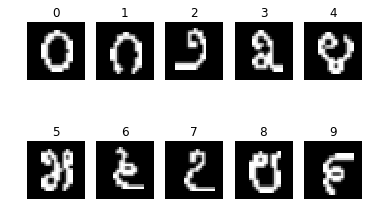

In [6]:
ttf_path='./fonts/Kannada/Lohit-Kannada.ttf'
font_size=18
seed_lohit_kannada=np.zeros((10,28,28))
for i in range(10):
  glyph_i=df.loc[(df.num==i)&(df.language=='Kannada'), 'glyph'].values[0]
  im_i=glyph_to_image(glyph_i, ttf_path, font_size, viz=False)
  seed_lohit_kannada[i,:,:]=im_i
###############
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(seed_lohit_kannada[i,:,:],cmap='gray')
  plt.axis('off')
  plt.title(i)

plt.savefig('./figures/seed_kannada_lohit.png',dpi=300)
  

# Save the data

In [0]:
np.save('./data/output_tensors/synthetic/seed_lohit_kannada.npy', seed_lohit_kannada)

# Images for showcasing some of the interesting challenges of the dataset.

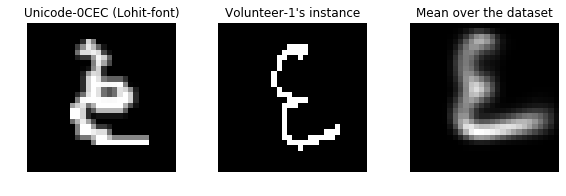

In [8]:
x=np.load('./data/output_tensors/X_Kannada_mnist.npy')
y=np.load('./data/output_tensors/y_Kannada_mnist.npy')
plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
plt.imshow(seed_lohit_kannada[6,:,:],cmap='gray')
plt.axis('off')
plt.title('Unicode-0CEC (Lohit-font)')
plt.subplot(1,3,2)
plt.imshow(x[np.where(y==6)[0][0],:,:,0],cmap='gray')
plt.title('Volunteer-1\'s instance')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.mean(x[y==6,:,:,0],axis=0),cmap='gray')
plt.axis('off')
plt.title('Mean over the dataset')
plt.tight_layout()
plt.savefig('./figures/six_deformations.pdf')

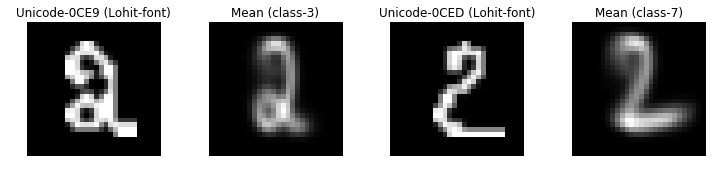

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(seed_lohit_kannada[3,:,:],cmap='gray')
plt.axis('off')
plt.title('Unicode-0CE9 (Lohit-font)')
plt.subplot(1,4,3)
plt.imshow(seed_lohit_kannada[7,:,:],cmap='gray')
plt.axis('off')
plt.title('Unicode-0CED (Lohit-font)')
plt.subplot(1,4,2)
plt.imshow(np.mean(x[y==3,:,:,0],axis=0),cmap='gray')
plt.axis('off')
plt.title('Mean (class-3)')
plt.subplot(1,4,4)
plt.imshow(np.mean(x[y==7,:,:,0],axis=0),cmap='gray')
plt.axis('off')
plt.title('Mean (class-7)')
plt.tight_layout()
plt.savefig('./figures/three_seven.pdf')
plt.savefig('./figures/three_seven.png',dpi=300)

# Now, let's repeat for other ttf files as well.
Sources:
http://salrc.uchicago.edu/resources/fonts/available/kannada/

http://brahmi.sourceforge.net/downloads.html

https://osdn.net/projects/sfnet_brahmi/downloads/Brahmi%20OpenType%20Fonts/OpenType%20font%20for%20Kannada%20-%20Sampige%20Ver%201.0/Sampige.ttf/

https://github.com/ShandonType/Benne/blob/master/TTF/Benne-Regular.ttf

https://github.com/erinmclaughlin/Hubballi

In [0]:
# ttf_files=os.listdir('./fonts/Kannada')
ttf_files=['Kedage-b.TTF',
 'Malige-i.TTF',
 'Malige-n.TTF',
 'Malige-b.TTF',
 'Kedage-n.TTF',
 'Malige-t.TTF',
 'Kedage-t.TTF',
 'Kedage-i.TTF',
 'Lohit-Kannada.ttf',
 'Sampige.ttf',
 'Hubballi-Regular.ttf']

In [11]:
n_ttf_files=len(ttf_files)
n_ttf_files

11

Kedage-b.TTF
Malige-i.TTF
Malige-n.TTF
Malige-b.TTF
Kedage-n.TTF
Malige-t.TTF
Kedage-t.TTF
Kedage-i.TTF
Lohit-Kannada.ttf
Sampige.ttf
Hubballi-Regular.ttf


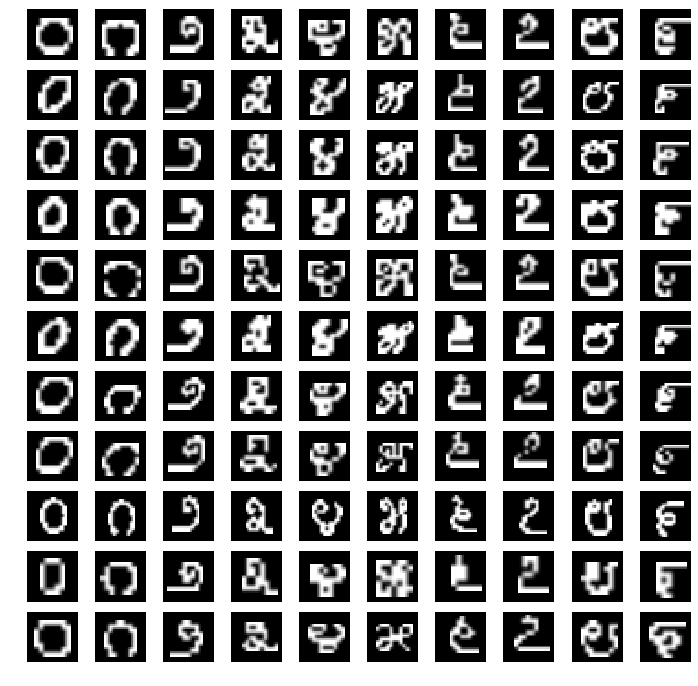

In [12]:
font_size=18
seed_kannada=np.zeros((n_ttf_files,10,28,28))
for f_ind,ttf_file in enumerate(ttf_files):
  ttf_path='./fonts/Kannada/'+ttf_file
  print(ttf_file)
  for i in range(10):
    glyph_i=df.loc[(df.num==i)&(df.language=='Kannada'), 'glyph'].values[0]
    ttf_path='./fonts/Kannada/'+ttf_file
    im_i=glyph_to_image(glyph_i, ttf_path, font_size, viz=False)
    seed_kannada[f_ind,i,:,:]=im_i
###############
c=1
plt.figure(figsize=(12,12))
for i in range(n_ttf_files):
  for j in range(10):
    
    plt.subplot(n_ttf_files,10,c)
    c+=1
    plt.imshow(seed_kannada[i,j,:,:],cmap='gray')
    plt.axis('off')

plt.savefig('./figures/seed_kannada_allfonts.png',dpi=300)
np.save('./data/output_tensors/synthetic/seed_allfonts_kannada.npy', seed_kannada)  
np.save('./data/output_tensors/synthetic/seednames_allfonts_kannada.npy', np.array(ttf_files) )